In [1]:
output_folder = "../output/"

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from numba import jit
import datetime
import seaborn as sns
from sklearn import cluster
from sklearn import mixture
from sklearn.preprocessing import normalize
import time

start_t = time.time()

# Section x: Heterogeneity

In [3]:
# import data
sessions = pd.read_csv('../data/opp.csv')
sessions = sessions.drop("Unnamed: 0", 1)
# Clean Sessions dataset
sessions['Session Start'] = pd.to_datetime(sessions['Session Start'])
sessions['My C Won'] = sessions['My C Won'
                               ].replace(to_replace='\$',value='', regex=True
                               ).replace(to_replace='\,',value='', regex=True
                               ).astype('float')
sessions['Won'] = sessions['Won'
                          ].replace(to_replace='\$',value='', regex=True
                          ).replace(to_replace='\,',value='', regex=True
                          ).astype('float')
sessions['BB vs SB call won'] = sessions['BB vs SB call won'
                                        ].replace(to_replace='\$',value='', regex=True
                                        ).replace(to_replace='\,',value='', regex=True
                                        ).astype('float')
sessions['won when 3bet pre'] = sessions['won when 3bet pre'
                                        ].replace(to_replace='\$',value='', regex=True
                                        ).replace(to_replace='\,',value='', regex=True
                                        ).astype('float')
sessions['Hands'] = sessions['Hands'
                            ].replace(to_replace='\,',value='', regex=True
                            ).astype('float')

for var_name in ['Fold BB v SB', 'VPIP', 'CBet F', '3Bet PF',
       'StdDev(BB/100)', 'BB/100', 'All-In Adj BB', 'My C StdDev', 
        'StdDev', 'WWSF', 'WTSD %', 'My C Rake Share', 'Rake Share', 
        'Total AF', 'Donk F', 'Att To Steal']:
    sessions[var_name] = pd.to_numeric(sessions[var_name
                              ].replace('\$','',regex=True
                              ).replace(to_replace='\,',value='', regex=True)
                          , errors='coerce')

sessions.fillna(0.0, inplace=True)

In [4]:
# Label ephemeral players
before = sessions[sessions['Session Start'] < "2014-11-03"]
during = sessions[sessions['Session Start'] > "2014-11-03"]
during = during[during['Session Start'] < "2015-01-06"]
after = sessions[sessions['Session Start'] > "2015-01-06"]
# Ampersand is set intersection
players_before = list(set(before['Player']) & set(during['Player']))
players_after = list(set(during['Player']) & set(after['Player']))
players_list = list(set(players_before + players_after))

sessions['ephemeral'] = ~sessions['Player'].isin(players_list)
sessions['ephemeral opp'] = ~sessions['Opponent'].isin(players_list)

**Labelling**

In [5]:
# Create weighed averages in groups
hands_weights = np.array(sessions['Hands'])
tmp = sessions.drop('Session Start',1
             ).drop('Player',1
             ).drop('ephemeral opp',1
             ).drop('Opponent',1)
sessions_avg = hands_weights[:, None] * tmp
sessions_avg['Player'] = sessions['Player']

In [6]:
# Group by player name
sessions_sum = sessions.groupby(sessions['Player']).sum()
sessions_avg = sessions_avg.groupby(sessions_avg['Player']).sum()
sessions_avg.drop('Player', 1, inplace=True)

# Divide results in sessions average by sum weight
hands_sum_weights = np.array(sessions_sum['Hands'])
sessions_avg = np.divide(sessions_avg, hands_sum_weights[:, None])

# Create cross-section of players over sample
players = sessions_avg.drop(sessions_avg.columns, 1)
players['Sessions'] = sessions_sum['Sessions']
players['Minutes tot'] = sessions_sum['Minutes']
players['Minutes avg'] = sessions_avg['Minutes']
players['Hands tot'] = sessions_sum['Hands']
players['Hands avg'] = sessions_avg['Hands']
# Winnings with RB
# 0.4 is the rakeback maximum on pokerstars at the time
# This is the most conservative way to estimate 
# since we can't kow what RB tier the player was on
players['Winnings'] = sessions_sum['My C Won'] + 0.4*sessions_sum['My C Rake Share']
players['My C Won tot'] = sessions_sum['My C Won']
players['My C Won avg'] = sessions_avg['My C Won']
players['My C StdDev avg'] = sessions_avg['My C StdDev']
players['My C Rake Share tot'] = sessions_sum['My C Rake Share']
players['My C Rake Share avg'] = sessions_avg['My C Rake Share']
players['All-In Adj BB tot'] = sessions_sum['All-In Adj BB']
players['All-In Adj BB avg'] = sessions_avg['All-In Adj BB']
players['BB/100 tot'] = sessions_sum['BB/100']
players['BB/100 avg'] = sessions_avg['BB/100']
players['StdDev(BB/100) tot'] = sessions_sum['StdDev(BB/100)']
players['StdDev(BB/100) avg'] = sessions_avg['StdDev(BB/100)']
for col_name in ['Fold BB v SB', 'VPIP',
                 'CBet F', '3Bet PF', 'WWSF', 'WTSD %', 'Total AF',
                 'Donk F', 'Att To Steal']:
    players[col_name] = sessions_avg[col_name]
players.fillna(0, inplace=True)

**Clustering**

In [7]:
clustering_cols = [
'Sessions', 'Minutes tot', 'Minutes avg', 'Hands tot', 'Hands avg',
'Winnings', 'My C Won tot', 'My C Won avg', 'My C StdDev avg',
'My C Rake Share tot', 'My C Rake Share avg', 'All-In Adj BB tot',
'All-In Adj BB avg', 'BB/100 tot', 'BB/100 avg', 'StdDev(BB/100) tot',
'StdDev(BB/100) avg', 'Fold BB v SB', 'VPIP', 'CBet F', '3Bet PF',
'WWSF', 'WTSD %', 'Total AF', 'Donk F', 'Att To Steal'
]
# Normalize data for clustering
# Non-normalized data will screw up the metric space calculations
# Because different dimensions will be scaled differently
cluster_data = players[clustering_cols].copy()
# Normalize data
for col_ in clustering_cols:
    cluster_data[col_] = (cluster_data[col_] - cluster_data[col_].mean()
                          ) / cluster_data[col_].std()

In [8]:
k_means = cluster.KMeans(init='k-means++', n_clusters=2, n_init=20).fit(cluster_data)
players['kmeans'] = k_means.labels_
k_means3 = cluster.KMeans(init='k-means++', n_clusters=3, n_init=20).fit(cluster_data)
players['kmeans3'] = k_means3.labels_

In [9]:
agglo = cluster.AgglomerativeClustering(n_clusters=2).fit(cluster_data)
players['agglo'] = agglo.labels_
agglo3 = cluster.AgglomerativeClustering(n_clusters=3).fit(cluster_data)
players['agglo3'] = agglo3.labels_

TODO: add DBScan and HDBScan for validation

**T-statistic clustering**

In [10]:
# T statistic on if player is an AIEV winner
# Equivalent pokertracker SQL code is
# (amt_expected_bb_won)/(sqrt((cnt_hands / 100)*(val_stddev_bb)*(val_stddev_bb)))
players['t stat won'] = (players['All-In Adj BB tot'] / 
                           np.sqrt(players['Hands tot'] / 
                            (100 * players['StdDev(BB/100) avg']**2)
                           ))
# Don't need to divide hands by 100 here since stddev is not a bb/100 measure
players['t stat won C'] = (players['Winnings'] / 
                           np.sqrt(players['Hands tot'] * 
                           (players['My C StdDev avg']**2)
                           ))
# t statistic on prob of being a winner
# Added restriction of having played at least x minutes
players['is winner'] = ((players['Minutes tot'] > 3600) & (players['t stat won'] > 1.645))
players['is winner C'] = ((players['Minutes tot'] > 3600) & (players['t stat won C'] > 1.645))

**Plot Clusters**

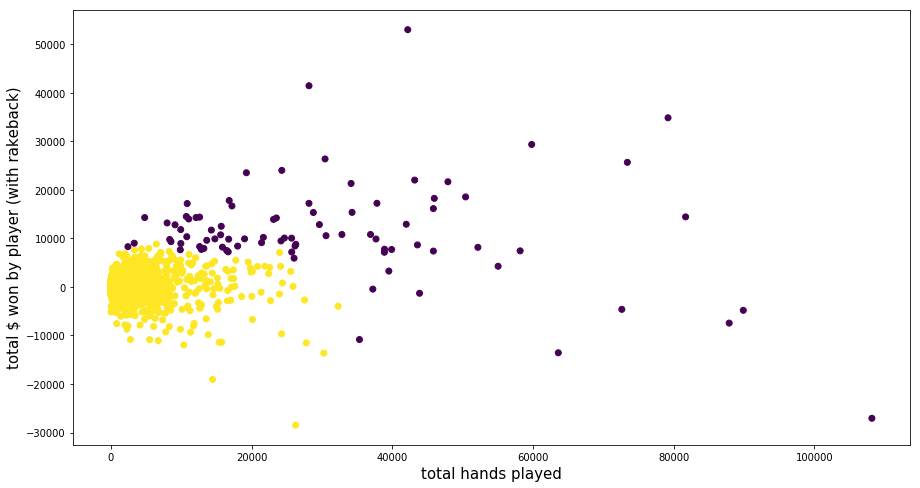

Total Labeled:  86 
Total players:  12092


In [11]:
# One of ['is winner', 'kmeans', 'agglo', 
#         'kmeans3', 'agglo3', 'is winner C']
# eg. the custering columns added above
to_plot = "agglo"
# ScatterPlot of hands played vs $ won total
xsize=15
ysize=8
fig, ax1 = plt.subplots(figsize=(xsize, ysize))
ax1.set_ylabel('total $ won by player (with rakeback)', size=15)
ax1.set_xlabel('total hands played', size=15)
scat = plt.scatter(players['Hands tot'], players['Winnings'], c=1 - players[to_plot])
plt.show()
print("Total Labeled: ", (players[to_plot] == 1).sum(), 
      "\nTotal players: ", len(players))

TODO

TODO

TODO

**Check clustering agreement**

**Output Plots To Folder**

**Pass results off to next section**

In [12]:
k_means_good = players[players['kmeans'] == 1]
k_means_bad = players[players['kmeans'] != 1]
agglo_good = players[players['agglo'] == 1] # Verify this is always the same
agglo_bad = players[players['agglo'] != 1]
t_C_good = players[players['is winner C'] == 1]
t_C_bad = players[players['is winner C'] != 1]
t_good = players[players['is winner'] == 1]
t_bad = players[players['is winner'] != 1]

sessions_new = sessions.copy()
agglo_names = players[players['agglo'] == 1].index
k_means_names = players[players['kmeans'] == 1].index
t_C_names = players[players['is winner C'] == 1].index
t_names = players[players['is winner'] == 1].index

sessions_new['agglo'] = (1 - sessions_new['Player'].isin(agglo_names))
sessions_new['kmeans'] = (sessions_new['Player'].isin(k_means_names)).astype(int)
sessions_new['t_C_cluster'] = (sessions_new['Player'].isin(t_C_names)).astype(int)
sessions_new['t_cluster'] = (sessions_new['Player'].isin(t_names)).astype(int)
sessions_new['before/during'] = (sessions_new['Player'].isin(players_before)).astype(int)
sessions_new['during/after'] = (sessions_new['Player'].isin(players_after)).astype(int)

sessions_new['agglo opp'] = (1 - sessions_new['Opponent'].isin(agglo_names))
sessions_new['kmeans opp'] = (sessions_new['Opponent'].isin(k_means_names)).astype(int)
sessions_new['t_C_cluster opp'] = (sessions_new['Opponent'].isin(t_C_names)).astype(int)
sessions_new['t_cluster opp'] = (sessions_new['Opponent'].isin(t_names)).astype(int)
sessions_new['before/during opp'] = (sessions_new['Opponent'].isin(players_before)).astype(int)
sessions_new['during/after opp'] = (sessions_new['Opponent'].isin(players_after)).astype(int)

In [13]:
cluster_output_name = output_folder + 'opponents_new.csv'
sessions_new.to_csv(cluster_output_name, encoding='utf8', index=False)
# clean up between logically separated sections
sessions = None
sessions_new = None

# Section X: Plot

**NOTE** This runs parallel to Regressions section

In [14]:
sessions = pd.read_csv('../data/opponents.csv')
sessions = sessions.drop('Unnamed: 0', 1).drop(sessions.loc[:, 'Time^2':], 1)
sessions['Session Start'] = pd.to_datetime(sessions['Session Start'])
sessions['wage'] = (sessions['My C Won']/sessions['Minutes'])*60
sessions['BB EV'] = (sessions['BB vs SB call won (bb)']/sessions['BB vs SB call cnt']).fillna(0)

ephemerals  = sessions[sessions['ephemeral'] == 1]
sessions = sessions[sessions['ephemeral'] != 1]

sessionskmc = sessions[sessions['k means'] == 1]
sessionskmcNOT = sessions[sessions['k means'] != 1]
sessionstc = sessions[sessions['t_cluster'] == 1]
sessionstcNOT = sessions[sessions['t_cluster'] != 1]
sessionsagglo = sessions[sessions['agglo'] == 1]
sessionsaggloNOT = sessions[sessions['agglo'] != 1]

In [15]:
def make_hourly_daily(sess):
    hourly = sess.copy(deep=True)
    hourly = hourly.drop(sess.loc[:, 'Total AF':'during/after'], 1)\
                     .drop(sess.loc[:, 'Time':'Time'], 1)#\
                    #.drop(sess.loc[:, 'Fold BB v SB':'WTSD %'], 1)\

    daily = sess.copy(deep=True)
    daily = daily.drop(sess.loc[:, 'Total AF':'during/after'], 1)\
                     .drop(sess.loc[:, 'Time':'Time'], 1)#\
                    #.drop(sess.loc[:, 'Fold BB v SB':'WTSD %'], 1)\

    hourly = hourly.set_index('Session Start')
    daily = daily.set_index('Session Start')

    daily_avg = daily.groupby(pd.TimeGrouper('1440Min')).mean()
    hourly_avg = hourly.groupby(pd.TimeGrouper('60Min')).mean()
    daily = daily.groupby(pd.TimeGrouper('1440Min')).sum()
    hourly = hourly.groupby(pd.TimeGrouper('60Min')).sum()

    hourly.loc[:, 'Treat':'11PM'] = hourly_avg.loc[:, 'Treat':]
    daily.loc[:, 'Treat':'11PM'] = daily_avg.loc[:, 'Treat':]

    hourly['wage'] = hourly_avg['wage']
    daily['wage'] = daily_avg['wage']
    hourly['Minutes avg'] = hourly_avg['Minutes']
    daily['Minutes avg'] = daily_avg['Minutes']
    hourly['Hands avg'] = hourly_avg['Hands']
    daily['Hands avg'] = daily_avg['Hands']
    hourly['My C Won avg'] = hourly_avg['My C Won']
    daily['My C Won avg'] = daily_avg['My C Won']
    hourly['My C Rake Share avg'] = hourly_avg['My C Rake Share']
    daily['My C Rake Share avg'] = daily_avg['My C Rake Share']
    
    daily['BB EV'] = (daily['BB vs SB call won (bb)']/daily['BB vs SB call cnt']).fillna(0)
    hourly['BB EV'] = (hourly['BB vs SB call won (bb)']/hourly['BB vs SB call cnt']).fillna(0)
    
    hourly = hourly.fillna(0)
    daily = daily.fillna(0)
    
    return hourly, daily

In [16]:
hourly, daily = make_hourly_daily(sessions)
hourlykmc, dailykmc = make_hourly_daily(sessionskmc)
hourlykmcnot, dailykmcnot = make_hourly_daily(sessionskmcNOT)
hourlytc, dailytc = make_hourly_daily(sessionstc)
hourlytcnot, dailytcnot = make_hourly_daily(sessionstcNOT)
hourlyagglo, dailyagglo = make_hourly_daily(sessionsagglo)
hourlyagglonot, dailyagglonot = make_hourly_daily(sessionsaggloNOT)
hourlyeph, dailyeph = make_hourly_daily(ephemerals)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  app.launch_new_instance()


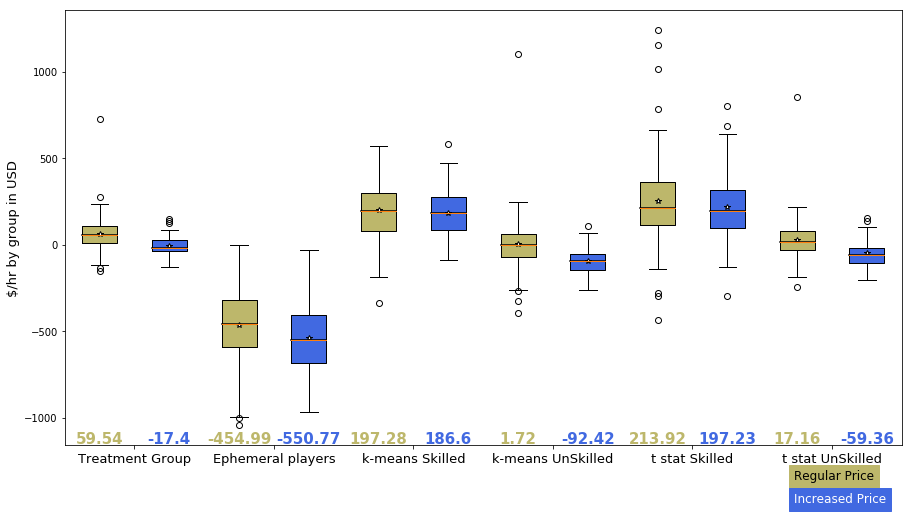

In [17]:
xsize=15
ysize=8
fig, ax1 = plt.subplots(figsize=(xsize, ysize))

data = [daily[daily['Treat'] == 0]['wage'], 
        daily[daily['Treat'] != 0]['wage'],
        dailyeph[dailyeph['Treat'] == 0]['wage'],
        dailyeph[dailyeph['Treat'] != 0]['wage'],
        dailykmc[dailykmc['Treat'] == 0]['wage'],
        dailykmc[dailykmc['Treat'] != 0]['wage'],
        dailykmcnot[dailykmcnot['Treat'] == 0]['wage'],
        dailykmcnot[dailykmcnot['Treat'] != 0]['wage'],
        dailytc[dailytc['Treat'] == 0]['wage'],
        dailytc[dailytc['Treat'] != 0]['wage'],
        dailytcnot[dailytcnot['Treat'] == 0]['wage'],
        dailytcnot[dailytcnot['Treat'] != 0]['wage'],
        #dailyagglo[dailyagglo['Treat'] == 0]['wage'],
        #dailyagglo[dailyagglo['Treat'] != 0]['wage'],
        #dailyagglonot[dailyagglonot['Treat'] == 0]['wage'],
        #dailyagglonot[dailyagglonot['Treat'] != 0]['wage']
       ]

bp = plt.boxplot(data)

ax1.set_ylabel('$/hr by group in USD', size=13)
ax1.set_xticklabels(['Treatment Group', 'Ephemeral players', 'k-means Skilled', 'k-means UnSkilled',
                     't stat Skilled', 't stat UnSkilled', 'agglo skilled', 'agglo unskilled'], size=13)
ax1.set_xticks([1.5, 3.5, 5.5, 7.5, 9.5, 11.5])

boxColors = ['darkkhaki', 'royalblue']
medians = list(range(len(data)))
for i in range(len(data)):
    box = bp['boxes'][i]
    boxX = []
    boxY = []
    for j in range(5):
        boxX.append(box.get_xdata()[j])
        boxY.append(box.get_ydata()[j])
    boxCoords = list(zip(boxX, boxY))
    # Alternate between Dark Khaki and Royal Blue
    k = i % 2
    boxPolygon = plt.Polygon(boxCoords, facecolor=boxColors[k])
    ax1.add_patch(boxPolygon)
    # Now draw the median lines back over what we just filled in
    med = bp['medians'][i]
    medianX = []
    medianY = []
    for j in range(2):
        medianX.append(med.get_xdata()[j])
        medianY.append(med.get_ydata()[j])
        plt.plot(medianX, medianY, 'k')
        medians[i] = medianY[0]
    # Finally, overplot the sample averages, with horizontal alignment
    # in the center of each box
    plt.plot([np.average(med.get_xdata())], [np.average(data[i])],
             color='w', marker='*', markeredgecolor='k')
    

# Due to the Y-axis scale being different across samples, it can be
# hard to compare differences in medians across the samples. Add upper
# X-axis tick labels with the sample medians to aid in comparison
# (just use two decimal places of precision)
pos = np.arange(len(data)) + 1
upperLabels = [str(np.round(s, 2)) for s in medians]
weights = ['bold', 'semibold']
for tick in range(len(data)):
    k = tick % 2
    ax1.text(pos[tick], -1150, upperLabels[tick],
             horizontalalignment='center', size=15, weight=weights[k],
             color=boxColors[k])
    

# Finally, add a basic legend
plt.figtext(0.80, 0.065, 'Regular Price',
            backgroundcolor=boxColors[0], color='black', weight='roman',
            size='12')
plt.figtext(0.80, 0.025, 'Increased Price',
            backgroundcolor=boxColors[1],
            color='white', weight='roman', size=12)

plt.show()

# Section x + 1: Regressions

**Read and clean data**

This data is all hands played on each hour on the site restricted to subsets where either a player played both before and during shock or during and after.

In [18]:
# Sample on ephemeral players only
#sessions = pd.read_csv(output_folder + 'suckers.csv')
# Regular players
#sessions = pd.read_csv(output_folder + 'sessions_prepared.csv')
# Full Sample
sessions = pd.read_csv(cluster_output_name)

sessions = sessions.drop(sessions.loc[:, 'Time^2':'logminutes'], 1)
sessions['Session Start'] = pd.to_datetime(sessions['Session Start'])

sessions['wage'] = (sessions['My C Won'] / sessions['Minutes']) * 60
sessions['BB call EV'] = (sessions['BB vs SB call won (bb)']/sessions['BB vs SB call cnt'])
sessions['BB 3b EV'] = (sessions['won when 3bet pre']
                        /sessions['BB vs SB 3b cnt']
                       ).replace([np.inf, -np.inf], np.nan
                       ).fillna(0.0)
sessions['BB continue EV'] =((sessions['BB vs SB call won (bb)'] 
                               + sessions['won when 3bet pre']
                            )/(sessions['BB vs SB 3b cnt'] 
                               + sessions['BB vs SB call cnt'])
                            ).replace([np.inf, -np.inf], np.nan
                            ).fillna(0.0)

In [19]:
#
# Hands/minutes/sessions since treat
#
# set subsample!
#
sessions = sessions[sessions['ephemeral'] != 1]
sessions = sessions[sessions['k means'] == 0]
#sessions = sessions[sessions['BB vs SB call cnt'] > 0]
#
#
#panel = sessions.set_index(['Session Start', 'Player'])

#daily_sessions = sessions.groupby(sessions.set_index('Session Start').index.date).mean()
#plt.plot(daily_sessions['My C Won'])

In [20]:
hourly = sessions.copy(deep=True)
hourly = hourly.drop(sessions.loc[:, 'Fold BB v SB':'during/after'], 1)\
                 .drop(sessions.loc[:, 'Time':'Time'], 1)

daily = sessions.copy(deep=True)
daily = daily.drop(sessions.loc[:, 'Fold BB v SB':'during/after'], 1)\
                 .drop(sessions.loc[:,'Midnight':'Time'], 1) 

hourly = hourly.set_index('Session Start')
daily = daily.set_index('Session Start')
daily_avg = daily.groupby(pd.Grouper(freq='1440Min')).mean()
hourly_avg = hourly.groupby(pd.Grouper(freq='60Min')).mean()
daily = daily.groupby(pd.Grouper(freq='1440Min')).sum()
hourly = hourly.groupby(pd.Grouper(freq='60Min')).sum()
hourly.loc[:, 'Treat':] = hourly_avg.loc[:, 'Treat':]
daily.loc[:, 'Treat':] = daily_avg.loc[:, 'Treat':]
hourly['wage'] = hourly_avg['wage']
daily['wage'] = daily_avg['wage']
hourly['Minutes avg'] = hourly_avg['Minutes']
daily['Minutes avg'] = daily_avg['Minutes']
hourly['Hands avg'] = hourly_avg['Hands']
daily['Hands avg'] = daily_avg['Hands']
hourly['My C Won avg'] = hourly_avg['My C Won']
daily['My C Won avg'] = daily_avg['My C Won']

hourly = hourly.fillna(0)
daily = daily.fillna(0)

In [21]:
# Clean Sessions dataset
sessions = sessions.sort_values(by='Session Start')
sessions = sessions.reset_index()
sessions = sessions.drop('index', 1)

In [22]:
# New dataset from grouped sessions average daily
daily_sessions = sessions.copy()
daily_sessions2 = sessions.copy()
daily_sessions = daily_sessions.groupby(daily_sessions.set_index('Session Start').index.date).mean()
daily_sessions2 = daily_sessions2.groupby(daily_sessions2.set_index('Session Start').index.date).median()
daily_sessions = daily_sessions.loc[:, :'Sunday']
daily_sessions['Minutes_median'] = daily_sessions2['Minutes']

**OLS on hands and rake aggregates**

- Model on constant + dummies to test for intercept change

In [23]:
ols_est = sm.OLS(
        hourly['BB call EV'], 
        sm.add_constant(hourly.loc[:, 'Treat':'11PM']#.drop('After', 1)
    )).fit(cov_type='HC1')
#ols_est.summary()

In [24]:
# Output regressions

# for endog_name in ['My C Won', 'Hands', 'Hands avg', 'Minutes', 'Minutes avg', 'Sessions', 'My C Won avg', 'wage']:
#     ols_est = sm.OLS(
#         hourly[endog_name], 
#         sm.add_constant(hourly.loc[:, 'Treat':'11PM']#.drop('After', 1)
#     )).fit(cov_type='HC1')
    
#     ols_summary = ols_est.summary()
#     text_file = open(str(output_folder + "/hourly " + endog_name + " k means.txt"), "w")
#     text_file.write(ols_summary.as_text())
#     text_file.close()

In [25]:
#
# OLS with "Learning"
#
X3 = hourly.loc[:, 'After':'11PM']
X3 = X3.reset_index().drop('Session Start', 1)
# First cutoff @ 1453
X3['Week 1'] = ((X3.index >= 1453) & (X3.index < 1620)).astype(int)
X3['Week 2'] = ((X3.index >= 1620) & (X3.index < 1787)).astype(int)
X3['Week 3'] = ((X3.index >= 1787) & (X3.index < 1954)).astype(int)
X3['Week 4'] = ((X3.index >= 1954) & (X3.index < 2121)).astype(int)
X3['Week 5'] = ((X3.index >= 2121) & (X3.index < 2288)).astype(int)
X3['Week 6'] = ((X3.index >= 2288) & (X3.index < 2455)).astype(int)
X3['Week 7'] = ((X3.index >= 2455) & (X3.index < 2622)).astype(int)
X3['Week 8'] = ((X3.index >= 2622) & (X3.index < 2789)).astype(int)
X3['Week 9'] = ((X3.index >= 2789) & (X3.index < 2959)).astype(int)
# Second cutoff @ 2959
X3 = sm.add_constant(X3)

In [26]:
y_learn = hourly['BB call EV'].reset_index()['BB call EV']
ols_learn = sm.OLS(y_learn, X3).fit(cov_type='HC1')
#ols_learn.summary()

In [27]:
# Output to files
# for endog_name in ['My C Won', 'Hands', 'Hands avg', 'Minutes', 'Minutes avg', 'Sessions', 'My C Won avg', 'wage']:
#     y_learn = hourly[endog_name].reset_index()[endog_name]
#     ols_learn = sm.OLS(y_learn, X3).fit(cov_type='HC1')
    
#     ols_summary = ols_learn.summary()
#     text_file = open(str(output_folder + "/Hourly " + endog_name + " k means new -- Learn.txt"), "w")
#     text_file.write(ols_summary.as_text())
#     text_file.close()

# OLS on sessions panel (Fixed Effects)

In [28]:
# FE_panel = sm.add_constant(
#           sessions.loc[:, 'Treat':].drop('wage', 1).drop('Time', 1)\
#                   .join(pd.get_dummies(sessions['Player']))
#             ).astype(float)

#sessions = sessions[sessions['BB vs SB call cnt'] > 0]

FE_panel = pd.DataFrame(sessions['Player'])\
           .join(sessions['Opponent'])\
           .join(sessions.loc[:, 'Treat':'11PM'].astype(float))


for col in FE_panel.columns[2:]:
    FE_panel[col] -= FE_panel.groupby('Player')\
                             [col].transform('mean')
    FE_panel[col] -= FE_panel.groupby('Opponent')\
                             [col].transform('mean') 
        
        
FE_panel = sm.add_constant(FE_panel.drop('Player', 1)\
                              .drop('Opponent', 1))

FE_panel = FE_panel.loc[:, :'Treat'].join(
                    pd.get_dummies(sessions['kmeans opp']).iloc[:, 1])\
                    .join(sessions['ephemeral opp'].astype(float))

#FE_panel['ephemeral opp x treat'] = FE_panel['ephemeral opp'] * FE_panel['Treat']
#FE_panel['k means 0 x treat'] = (1 - sessions['k means opp']) * FE_panel['Treat']
#FE_panel['k means 1 x treat'] = sessions['k means opp'] * FE_panel['Treat']
reg_res = {}
for endog_name in ['Hands', 'My C Won', 'Minutes',
                   'Sessions', 'wage', 
                   'VPIP', 'CBet F', 'Total AF', '3Bet PF',
                   'BB call EV',
                   'BB continue EV',
                   'Fold BB v SB'
    ]:
    sessions_ols = sm.OLS(
        sessions[endog_name].fillna(0), 
        FE_panel
        ).fit(cov_type='HC1')   #NB: drop time if you want to
    reg_res[endog_name] = sessions_ols
    ols_summary = sessions_ols.summary()
    text_file = open(str(output_folder + endog_name + ".txt"), "w")
    text_file.write(ols_summary.as_text())
    text_file.close()

In [29]:
print("Runtime: ", time.time() - start_t)

Runtime:  168.12999415397644


In [30]:
reg_res

{'Hands': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x1b9cb3e1390>,
 'My C Won': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x1b992051438>,
 'Minutes': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x1b9919be9b0>,
 'Sessions': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x1b991954588>,
 'wage': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x1b9918eb278>,
 'VPIP': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x1b9918d8c18>,
 'CBet F': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x1b9918742b0>,
 'Total AF': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x1b991867668>,
 '3Bet PF': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x1b9917fc0f0>,
 'BB call EV': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x1b9842ca390>,
 'BB continue EV': <statsmodels.regression.linear_model.RegressionResults